# Definities

In [1]:
import numpy as np
import pandas as pd
from math import floor
import glob
import shapely
import geopandas as gp
from geopandas import GeoDataFrame, sjoin
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon
import shapely.speedups; shapely.speedups.enable()
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
import mplleaflet
from IPython.display import IFrame
import warnings; warnings.filterwarnings('ignore')

Er worden verschillende coördinatenreferentiesystemen aangehouden in de gebruikte data. Er moeten ook berekeningen gedaan kunnen worden op de geometrieën. Tot slot kiezen we voor een Mercatorprojectie voor de kaarten. 

In [2]:
crs = {'init': 'epsg:4326'}          # Standaard WGS84
amersfoort = {'init': 'epsg:28992'}  # Rijkscoördinatendriehoek
cea = {'proj':'cea'}                 # Equal area
mercator = {'init': 'epsg:3395'}     # Mercatorprojectie

tiny_forest_area = 80  # m²

In [3]:
def import_gebied(csv):
    df = pd.read_csv(csv, dtype=str, sep=';').drop(columns=['OBJECTNUMMER', 'WKT_LAT_LNG', 'LNG', 'LAT'])
    return df[df.columns.drop(df.filter(regex='Unnamed').columns)].rename(columns={'WKT_LNG_LAT':'geometry'})

def to_crs(gdf, crs=crs):
    gdf = gdf.to_crs(crs)
    gdf.crs = crs
    return gdf

def parkeervakken(gdf, stadsdeel=''):
    if stadsdeel:
        gdf = gdf[gdf.Stadsdeel == stadsdeel].geometry.copy()
    else:
        gdf = gdf.geometry.copy()
    gdf = GeoDataFrame(gdf.reset_index().drop(columns=['index']), crs=crs)
    return to_crs(gdf, crs=amersfoort)

def bewerkingen(gdf):
    gdf['aantal_vakken_per_m2'] = gdf.aantal_vakken / gdf.Opp_m2.astype(float)
    gdf['aantal_bomen_vakken'] = gdf.aantal_vakken.apply(lambda x: floor(x / (tiny_forest_area / 10)))
    gdf['aantal_bomen_opp'] = gdf.Oppervlakte.apply(lambda x: floor(x / tiny_forest_area))
    gdf['aantal_microbosjes'] = gdf[['aantal_bomen_vakken', 'aantal_bomen_opp']].max(axis=1)
    gdf['aantal_microbosjes_log'] = np.log(gdf['aantal_microbosjes'])
    return gdf

def parkeervakken_grouped(gdf, stadsdeel='', buurt=False):
    if stadsdeel:
        gdf = gdf[gdf.Stadsdeel == stadsdeel].copy()
    else:
        gdf = gdf.copy()
    if buurt:
        gdf['Buurt'] = pd.Categorical(gdf['Buurt'], categories=list(buurten[buurten.Stadsdeel_code=='A'].Buurt))
    gdf = GeoDataFrame(gdf.groupby(['Buurt'], as_index=False).sum()
                          .merge(buurten[['geometry', 'Buurtcode', 'Buurt', 'Opp_m2']], on=['Buurt'])
                          .drop(columns=['afstand_boven', 'afstand_onder']), 
                       crs=crs)
    return to_crs(bewerkingen(gdf), crs=amersfoort)

def parkeervakken_stadsdelen(gdf):
    gdf = GeoDataFrame(gdf.groupby(['Stadsdeel'], as_index=False).sum()
                          .merge(sd[['geometry', 'Stadsdeel_code', 'Stadsdeel', 'Opp_m2']], on=['Stadsdeel'])
                          .drop(columns=['afstand_boven', 'afstand_onder']), 
                       crs=crs)
    return to_crs(bewerkingen(gdf), crs=amersfoort)

def add_label_coords(gdf):
    gdf['coords'] = [coords[0] for coords in gdf['geometry'].apply(lambda x: x.representative_point().coords[:])]
    return gdf

# Importeren van data
De meeste data zijn afkomstig van maps.amsterdam.nl

Bomen worden in dit notebook nog niet gebruikt, grondgebruik wordt wel meegenomen

Door datasets te importeren voor alle mogelijke gebieden, wordt het later makkelijker om postcodes, buurten, en stadsdelen (en bijbehorende coördinaten) te koppelen. PC4 wordt hierbij vooralsnog niet gebruikt

In [4]:
# Om een koppeling te maken tussen postcodes, stadsdelen, en coordinaten: 
# pc4 = import_gebied('data/020/PC4_BUURTEN.csv')
pc6 = import_gebied('data/020/PC6_VLAKKEN_BAG.csv')
sd = import_gebied('data/020/GEBIED_STADSDELEN_EXWATER.csv')
buurten = import_gebied('data/020/GEBIED_BUURTEN_EXWATER.csv').rename(index=str, columns={'Buurt_code': 'Buurtcode'})

# We filteren buurten N73 in Noord weg
buurten = buurten[buurten.Buurtcombinatie_code != 'N73']

# pc4 = GeoDataFrame(pc4, crs=crs, geometry=pc4.geometry.apply(wkt.loads))
pc6 = GeoDataFrame(pc6, crs=crs, geometry=pc6.geometry.apply(wkt.loads))
sd = GeoDataFrame(sd, crs=crs, geometry=sd.geometry.apply(wkt.loads))
buurten = GeoDataFrame(buurten, crs=crs, geometry=buurten.geometry.apply(wkt.loads))

# Importeer parkeervakken-data
Hier wordt de data van parkeervakken geïmporteerd en bewerkt. De geodata in het .csv-bestand is in Rijksdriehoekscoördinaten (Amersfoort-projectie). 

Allereerst wordt buurt N73 in Noord gedropt. 

Vervolgens worden afstanden tussen en oppervlaktes van parkeervakken berekend. De data wordt gefilterd op een maximale tussengelegen afstand van 5 meter tussen parkeervakken die in dezelfde straat liggen, en minimaal vier parkeervakken per straat. Dit zorgt ervoor dat bomen ten minste

Tot slot wordt een kolom toegevoegd met informatie over eventuele strategische plannen voor het gebied waarin het parkeervak ligt. 

In [5]:
# Parkeervakken
pv = pd.read_csv('data/parkeervakken.csv').\
    rename(index=str, columns={'buurtcode': 'Buurtcode', 'WKT': 'geometry', 'aantal': 'aantal_vakken'})
pv['Buurtcombinatie_code'] = pv.Buurtcode.apply(lambda x: x[:3])

pv = pv[pv.Buurtcombinatie_code != 'N73'].\
    merge(buurten[['Buurtcode', 'Buurt', 'Stadsdeel_code']], on=['Buurtcode']).\
    merge(sd[['Stadsdeel', 'Stadsdeel_code']], on=['Stadsdeel_code']).\
    drop(columns=[
#     'Buurtcode', 
    'Buurtcombinatie_code', 'Stadsdeel_code'])

pv = pv.sort_values(['straatnaam', 'geometry']).reset_index(drop=True)

In [6]:
# GeoDataFrame maken van DataFrame, werken met copy!
gdf_pv = GeoDataFrame(pv.copy(), crs=amersfoort, geometry=pv.geometry.apply(wkt.loads))
gdf_pv['geometry'] = gdf_pv.geometry.to_crs(crs)  # naar leesbare coordinaten
gdf_pv.crs = crs  # voor de zekerheid

In [7]:
# Controleren of er minimaal twee parkeervakken naast elkaar zitten
gdf_tellen = GeoDataFrame(gdf_pv.copy(), crs=crs)
gdf_tellen['geometry'] = gdf_tellen.geometry.to_crs(cea)
gdf_tellen.crs = cea  # om afstanden en oppervlakte te kunnen berekenen

# Update bron-GeoDataFrame met afstanden tussen en oppervlakte van parkeervakken voor later gebruik
gdf_pv['Oppervlakte'] = gdf_tellen.geometry.area  # uitrekenen van oppervlakte

gdf_pv['afstand_boven'] = [np.nan] + [
    gdf_tellen.geometry.iloc[i].centroid.distance(gdf_tellen.geometry.iloc[i-1].centroid) 
    if gdf_tellen.straatnaam.iloc[i] == gdf_tellen.straatnaam.iloc[i-1] 
    else np.nan 
    for i in range(1, len(gdf_tellen))]

gdf_pv['afstand_onder'] = [
    gdf_tellen.geometry.iloc[i].centroid.distance(gdf_tellen.geometry.iloc[i+1].centroid) 
    if gdf_tellen.straatnaam.iloc[i] == gdf_tellen.straatnaam.iloc[i+1] 
    else np.nan 
    for i in range(len(gdf_tellen) - 1)] + [np.nan]

### Filteren

In [8]:
# Controleren of er minimaal vier parkeervakken in de straat zitten
vakken_per_straat = gdf_pv.groupby(['straatnaam'], as_index=False).sum()
gdf_pv = gdf_pv[gdf_pv.straatnaam.isin(vakken_per_straat[
    (vakken_per_straat.aantal_vakken >= (tiny_forest_area / 10)) | 
    (vakken_per_straat.Oppervlakte >= tiny_forest_area)].straatnaam)]

# # Filter data op parkeervakken die niet dicht naast elkaar liggen, adhv een afstand van 5+ meter met het vorige vak 
# gdf_pv = gdf_pv[
#     ((gdf_pv.afstand_boven < 5) | (gdf_pv.afstand_boven.isnull())) 
#     & ((gdf_pv.afstand_boven < 5) | (gdf_pv.afstand_onder.isnull()))]

del vakken_per_straat, gdf_tellen

# Plotten

In [9]:
# Maak GeoDataFrame met aantal parkeervakken per buurt voor alle stadsdelen
vakken_per_buurt = parkeervakken_grouped(gdf_pv)

# Maak GeoDataFrame met aantal parkeervakken per buurt in stadsdeel Centrum, inclusief labels
centrum = add_label_coords(parkeervakken_grouped(gdf_pv, 'Centrum', buurt=True))

# Maak GeoDataFrame met geometrie van parkeervakken voor alle stadsdelen
alle_vakken = parkeervakken(gdf_pv)

# Maak GeoDataFrame met geometrie van parkeervakken in stadsdeel Centrum
vakken = parkeervakken(gdf_pv, 'Centrum')

# Stadsdelen ook naar Mercatorprojectie
sd = add_label_coords(to_crs(sd, crs=amersfoort))

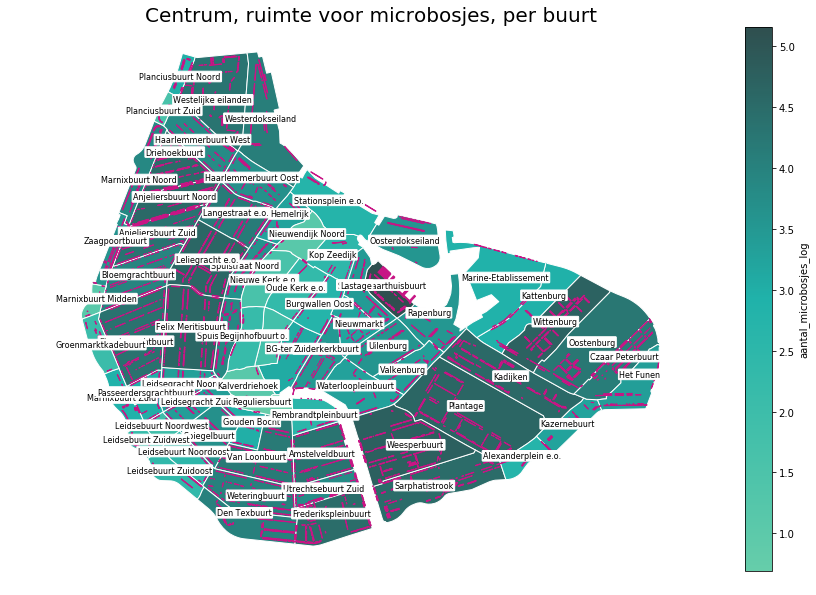

In [23]:
# Maak een plot van Amsterdam-Centrum met groene kleuring naar aantal plantbare bomen en in rood de vakken zelf

variable = 'aantal_microbosjes_log'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    '', ['darkslategrey', 'lightseagreen', 'mediumaquamarine'][::-1])

vmin = centrum[variable].min()
vmax = centrum[variable].max()

fig, ax = plt.subplots(1, figsize=(20, 10))

plt.axis('off')
plt.title('Centrum, ruimte voor microbosjes, per buurt', size=20)

centrum.plot(ax=ax, column=variable, cmap=cmap, linewidth=1, edgecolor='white')
vakken.plot(ax=ax, linewidth=1, color='mediumvioletred', edgecolor='mediumvioletred')

# plt.annotate(s='parkeervak', xy=(548500, 6836500))
# rect = patches.Rectangle(xy=(548250, 6836490), width=200, height=100, facecolor='mediumvioletred')
# ax.add_patch(rect)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel(variable)

# Gooi er een paar labels overheen
for idx, row in centrum.iterrows():
    plt.annotate(s=row['Buurt'], xy=row['coords'], horizontalalignment='center', size=8,
                bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.1'))

plt.savefig('Centrum.png')

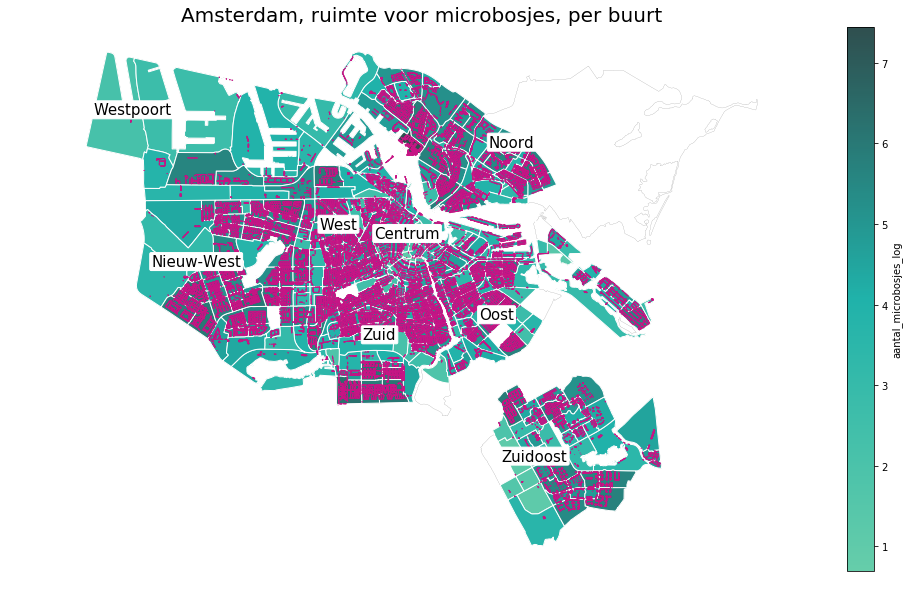

In [22]:
# Figuur: plantbare bomen per buurt 

scaler = 1
variable = 'aantal_microbosjes_log'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    '', ['darkslategrey', 'lightseagreen', 'mediumaquamarine'][::-1])

vmin = vakken_per_buurt[variable].min()
vmax = vakken_per_buurt[variable].max()

fig, ax = plt.subplots(1, figsize=(scaler*20, scaler*10))

plt.axis('off')
plt.title('Amsterdam, ruimte voor microbosjes, per buurt', size=scaler*20)

sd.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=scaler*.1)
vakken_per_buurt.plot(ax=ax, column=variable, cmap=cmap, linewidth=scaler*1, edgecolor='white')
alle_vakken.plot(ax=ax, linewidth=scaler*1, color='mediumvioletred', edgecolor='mediumvioletred')

# plt.annotate(s='parkeervak', xy=(565000, 6845000))
# rect = patches.Rectangle(xy=(564250, 6844900), width=800, height=400, facecolor='mediumvioletred')
# ax.add_patch(rect)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel(variable)

# Gooi er een paar labels overheen
for idx, row in sd.iterrows():
    plt.annotate(s=row['Stadsdeel'], xy=row['coords'], horizontalalignment='center', size=scaler*15, 
                 bbox=dict(facecolor='white', edgecolor='white', boxstyle=f'round,pad={scaler*.1}'))

plt.savefig('Amsterdam.png')

In [12]:
tabel = parkeervakken_stadsdelen(gdf_pv)[['Stadsdeel_code', 'Stadsdeel', 'aantal_microbosjes']].sort_values('Stadsdeel_code')
# tabel[['Stadsdeel', 'aantal_microbosjes']].to_csv('hejo.csv')
pd.concat([tabel[['Stadsdeel', 'aantal_microbosjes']], pd.DataFrame(dict(Stadsdeel='Amsterdam', aantal_microbosjes=tabel['aantal_microbosjes'].sum()), index=[0])], ignore_index=True)

,Stadsdeel,aantal_microbosjes
0,Centrum,3015
1,Westpoort,293
2,West,5789
3,Nieuw-West,11125
4,Zuid,9634
5,Oost,6146
6,Noord,9300
7,Zuidoost,5509
8,Amsterdam,50811


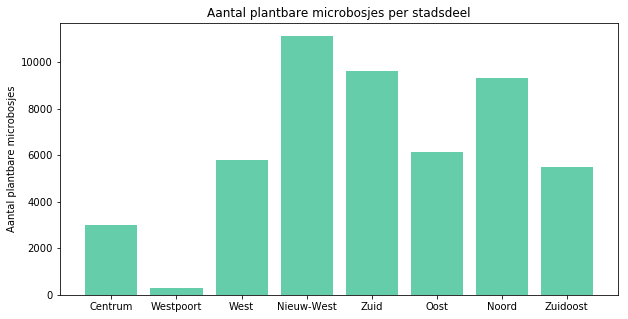

In [21]:
# Bar chart: bomen per stadsdeel

fig, ax = plt.subplots(1, figsize=(10, 5))

plt.bar(tabel.Stadsdeel, tabel.aantal_microbosjes, align='center', color='mediumaquamarine')

plt.ylabel('Aantal plantbare microbosjes')
plt.title('Aantal plantbare microbosjes per stadsdeel')

plt.savefig('Stadsdelen.png')

In [14]:
print(f'Aantal vierkante kilometers parkeervak in heel Amsterdam beschikbaar voor bomen is {round(gdf_pv.Oppervlakte.sum()/10**6)} km²')
print(f'Aantal microbosjes in heel Amsterdam is {int((gdf_pv.Oppervlakte.sum())/40)} uitgaande van oppervlak')
print(f'Aantal microbosjes in heel Amsterdam is {int((gdf_pv.aantal_vakken.sum())/4)} uitgaande van aantal vakken')

Aantal vierkante kilometers parkeervak in heel Amsterdam beschikbaar voor bomen is 3.0 km²
Aantal microbosjes in heel Amsterdam is 76221 uitgaande van oppervlak
Aantal microbosjes in heel Amsterdam is 65169 uitgaande van aantal vakken
